In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

In [ ]:
data = pd.read_csv("producer-prices_mar.csv")
df


,Iso3,StartDate,EndDate,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Months Code,Months,Unit,Value,Flag
0,#country+code,#date+start,#date+end,NaN,NaN,#country+name,#indicator+code,NaN,#indicator+name,NaN,NaN,NaN,#date+year,NaN,NaN,#indicator+type,#indicator+value+num,NaN
1,MAR,2004-01-01,2004-12-31,143.0,'504,Morocco,221,'01371,"Almonds, in shell",5530.0,Producer Price (LCU/tonne),2004.0,2004,7021.0,Annual value,LCU,2308.500000,A
2,MAR,2005-01-01,2005-12-31,143.0,'504,Morocco,221,'01371,"Almonds, in shell",5530.0,Producer Price (LCU/tonne),2005.0,2005,7021.0,Annual value,LCU,2675.000000,A
3,MAR,2021-01-01,2021-12-31,143.0,'504,Morocco,221,'01371,"Almonds, in shell",5530.0,Producer Price (LCU/tonne),2021.0,2021,7021.0,Annual value,LCU,15157.000000,A
4,MAR,2022-01-01,2022-12-31,143.0,'504,Morocco,221,'01371,"Almonds, in shell",5530.0,Producer Price (LCU/tonne),2022.0,2022,7021.0,Annual value,LCU,16102.000000,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8194,MAR,2018-01-01,2018-12-31,143.0,'504,Morocco,1800,'F1800,"Vegetables&Melons, Total",5539.0,Producer Price Index (2014-2016 = 100),2018.0,2018,7021.0,Annual value,NaN,63.470000,I
8195,MAR,2019-01-01,2019-12-31,143.0,'504,Morocco,1800,'F1800,"Vegetables&Melons, Total",5539.0,Producer Price Index (2014-2016 = 100),2019.0,2019,7021.0,Annual value,NaN,69.900000,I
8196,MAR,2020-01-01,2020-12-31,143.0,'504,Morocco,1800,'F1800,"Vegetables&Melons, Total",5539.0,Producer Price Index (2014-2016 = 100),2020.0,2020,7021.0,Annual value,NaN,75.500000,I
8197,MAR,2021-01-01,2021-12-31,143.0,'504,Morocco,1800,'F1800,"Vegetables&Melons, Total",5539.0,Producer Price Index (2014-2016 = 100),2021.0,2021,7021.0,Annual value,NaN,69.970000,I


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Iso3             8199 non-null   object 
 1   StartDate        8199 non-null   object 
 2   EndDate          8199 non-null   object 
 3   Area Code        8198 non-null   float64
 4   Area Code (M49)  8198 non-null   object 
 5   Area             8199 non-null   object 
 6   Item Code        8199 non-null   object 
 7   Item Code (CPC)  8198 non-null   object 
 8   Item             8199 non-null   object 
 9   Element Code     8198 non-null   float64
 10  Element          8198 non-null   object 
 11  Year Code        8198 non-null   float64
 12  Year             8199 non-null   object 
 13  Months Code      8198 non-null   float64
 14  Months           8198 non-null   object 
 15  Unit             3868 non-null   object 
 16  Value            8199 non-null   object 
 17  Flag          

In [ ]:
data.drop(0, axis=0, inplace=True)
data.sort_values(by="Year", inplace=True)
data.reset_index(drop=True, inplace=True)
data[['Item Code', 'Year']] = data[['Item Code', 'Year']].astype(int)
data['Value'] = data['Value'].astype(float)
data['StartDate'] = pd.to_datetime(data['StartDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])

In [ ]:
# Organize items into categories
categories = {
    "Grains": ["Wheat", "Rice", "Maize (corn)", "Barley", "Sorghum", "Rye", "Millet", "Oats"],
    "Fruits": ["Bananas", "Oranges", "Grapes", "Tangerines, mandarins, clementines", "Pears",
               "Peaches and nectarines", "Apples", "Apricots", "Plums and sloes", "Quinces",
               "Avocados", "Figs", "Pineapples", "Pomelos and grapefruits", "Mangoes, guavas and mangosteens",
               "Cranberries", "Blueberries", "Raspberries", "Strawberries", "Cherries", "Papayas"],
    "Vegetables": ["Tomatoes", "Potatoes", "Onions and shallots, dry (excluding dehydrated)",
                   "Carrots and turnips", "Cucumbers and gherkins", "Cabbages", "Cauliflowers and broccoli",
                   "Asparagus", "String beans", "Lettuce and chicory", "Leeks and other alliaceous vegetables",
                   "Green garlic", "Eggplants (aubergines)", "Artichokes", "Peas, green", "Peas, dry",
                   "Chillies and peppers, green (Capsicum spp. and Pimenta spp.)", "Chillies and peppers, dry (Capsicum spp., Pimenta spp.), raw",
                   "Pumpkins, squash and gourds", "Sweet potatoes", "Other beans, green", "Other vegetables, fresh n.e.c.",
                   "Lupins", "Locust beans (carobs)", "Walnuts, in shell"],
    "Meat & Dairy": ["Meat of chickens, fresh or chilled (biological)", "Meat of sheep, fresh or chilled",
                     "Meat of cattle with the bone, fresh or chilled (biological)", "Meat of pig with the bone, fresh or chilled",
                     "Meat of turkeys, fresh or chilled (biological)", "Meat of goat, fresh or chilled",
                     "Meat of camels, fresh or chilled (biological)", "Horse meat, fresh or chilled",
                     "Game meat, fresh, chilled or frozen", "Raw milk of cattle", "Hen eggs in shell, fresh",
                     "Raw milk of sheep", "Raw milk of goats", "Raw milk of camel"],
    "Others": ["Sunflower seed", "Groundnuts, excluding shelled", "Unmanufactured tobacco", "Seed cotton, unginned",
               "Almonds, in shell", "Beeswax", "Natural honey", "Rape or colza seed", "Other tropical fruits, n.e.c.",
               "Vetches", "Soya beans", "Other pulses n.e.c.", "Dates", "Shorn wool, greasy, including fleece-washed shorn wool",
               "Roots and Tubers, Total", "Other stimulant, spice and aromatic crops, n.e.c.", "Pulses, Total",
               "Coarse Grain, Total", "Sisal, raw", "Pistachios, in shell", "Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw",
               "Pyrethrum, dried flowers", "Vegetables&Melons, Total", "Treenuts, Total", "Meat, Total", "Other fruits, n.e.c.",
               "Other oil seeds, n.e.c.", "Oilcrops, Oil Equivalent", "Agriculture", "Castor oil seeds", "Fibre Crops Primary",
               "Cereals n.e.c.", "Cotton lint, ginned", "Eggs Primary", "Citrus Fruit, Total", "Fruit Primary",
               "Other berries and fruits of the genus vaccinium n.e.c.", "Fruit excl Melons, Total", "Other vegetables, fresh n.e.c.",
               "Horse meat, fresh or chilled (biological)", "Cereals, primary", "Livestock"]
}
item_to_category = {item: category for category, items in categories.items() for item in items}
data["Category"] = data["Item"].map(item_to_category)

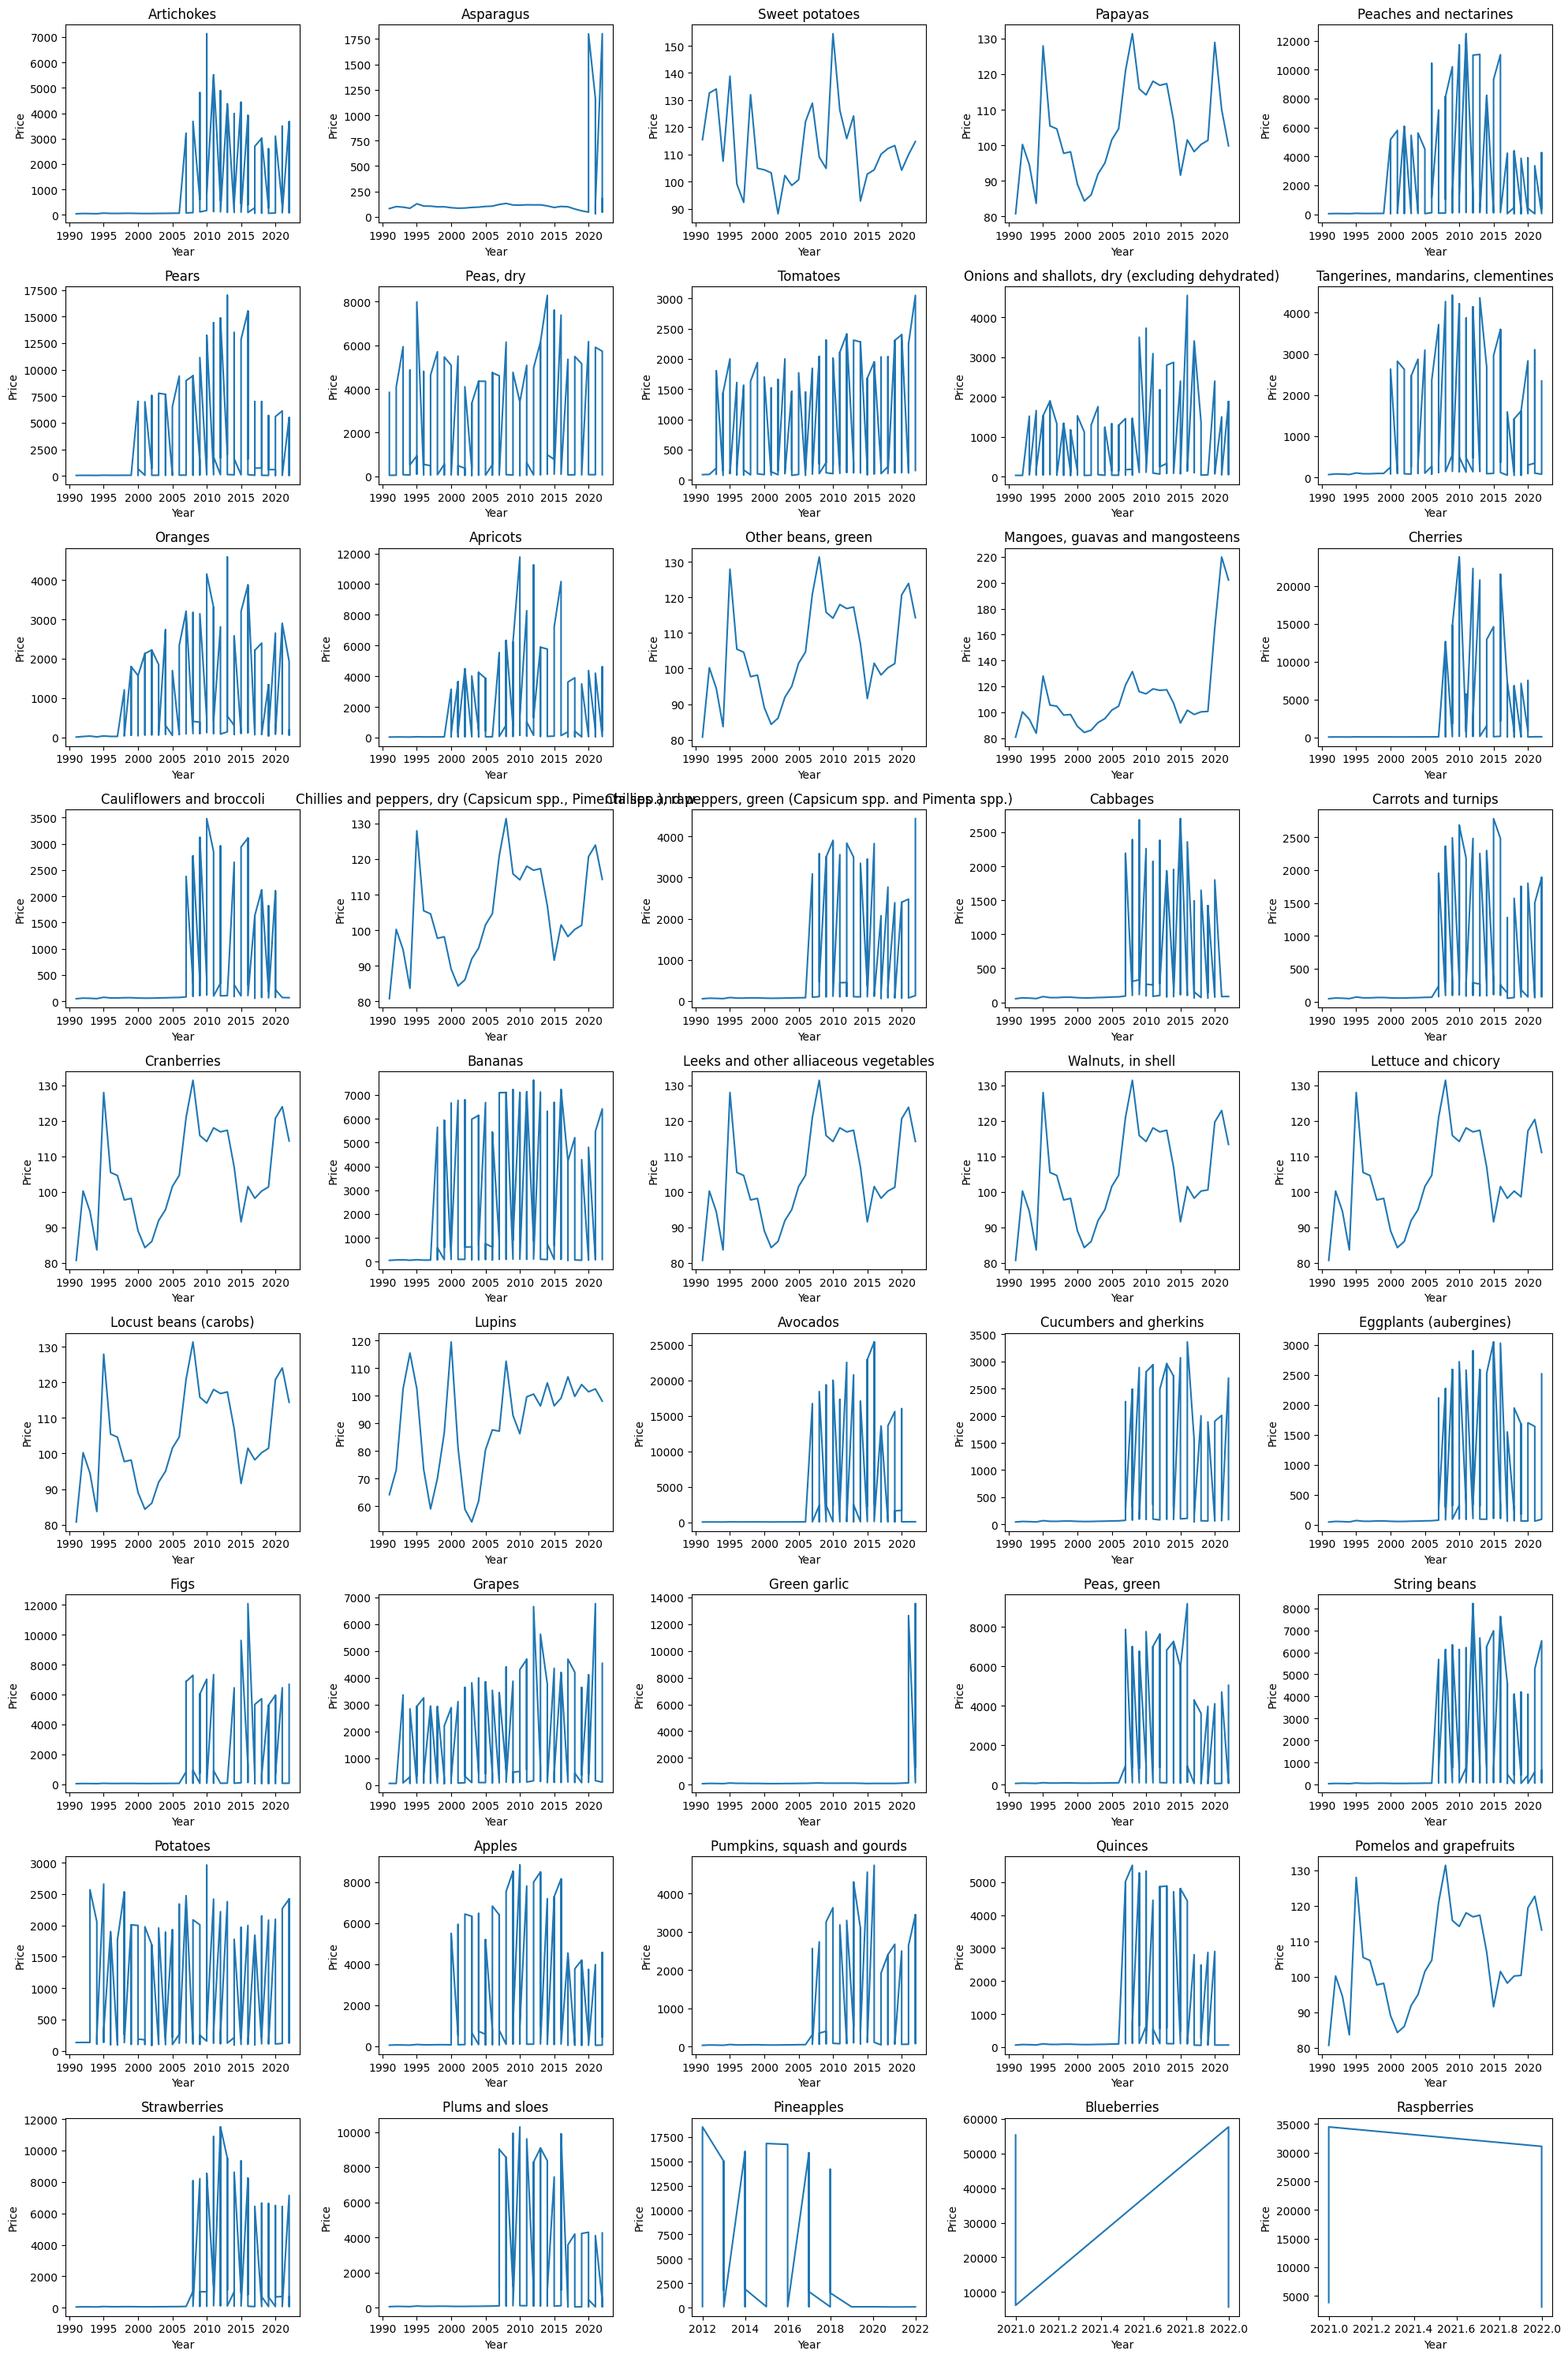

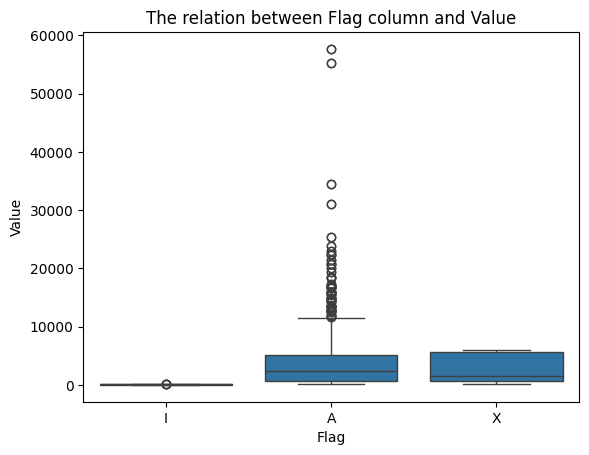

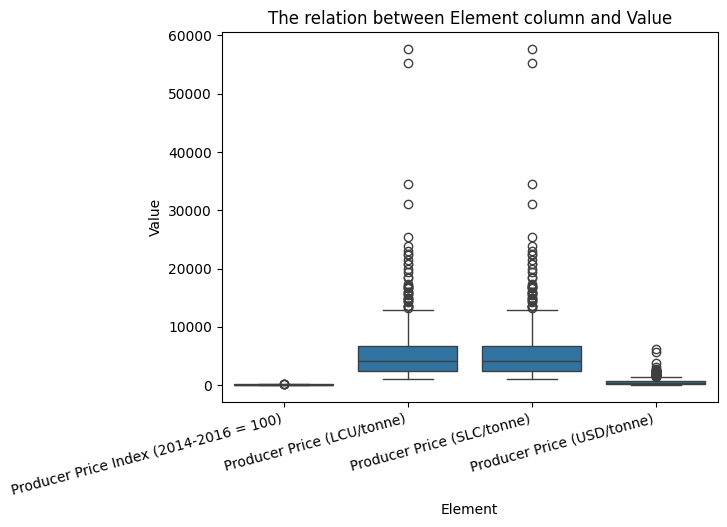

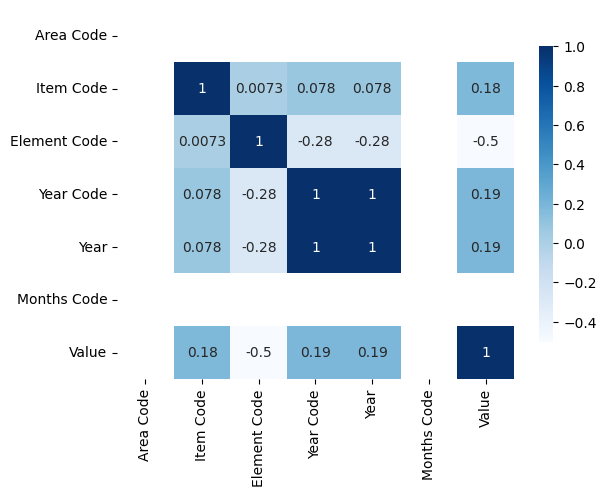

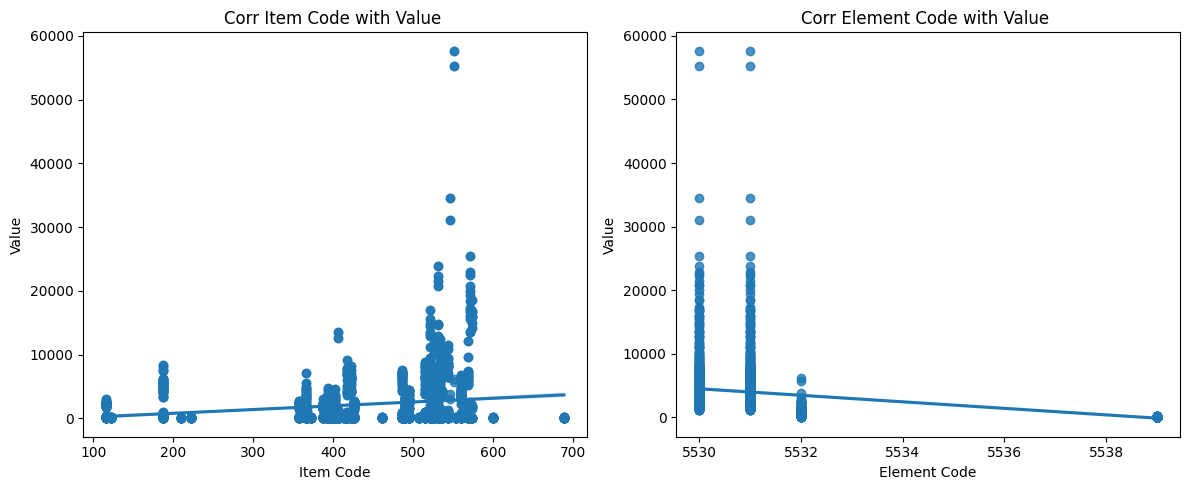

In [ ]:
#Data Visualization
data_vege_frui = data[(data['Category'] == "Fruits") | (data['Category'] == "Vegetables")]
data_vege_frui.reset_index(drop=True, inplace=True)

unique_items = data_vege_frui['Item'].unique()
num_rows = 9
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))

for i, item in enumerate(unique_items):
    row = i // num_cols
    col = i % num_cols
    item_data = data_vege_frui[data_vege_frui['Item'] == item]
    ax = axes[row, col]
    ax.plot(item_data['Year'], item_data['Value'])
    ax.set_title(item)
    ax.set_xlabel('Year')
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()

sns.boxplot(x='Flag', y='Value', data=data_vege_frui)
plt.title("The relation between Flag column and Value")
plt.show()

sns.boxplot(x='Element', y='Value', data=data_vege_frui)
plt.title("The relation between Element column and Value")
plt.xticks(rotation=15, ha='right')
plt.show()

numeric_data = data_vege_frui.select_dtypes(include=['float', 'int'])
sns.heatmap(numeric_data.corr(), annot=True, cmap="Blues", cbar_kws={"shrink": 0.8})
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x="Item Code", y="Value", data=numeric_data, ax=axes[0])
axes[0].set_title("Corr Item Code with Value ")

sns.regplot(x="Element Code", y="Value", data=numeric_data, ax=axes[1])
axes[1].set_title("Corr Element Code with Value ")
plt.tight_layout()
plt.show()

In [ ]:
#Machine Learning Model
X = data_vege_frui[['Item Code', 'Year']]
y = data_vege_frui['Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
#Model Deployment
def predict_price(item_code, year):
    """
    Predicts the price for a given item code and year.

    Args:
    item_code (int): Item code.
    year (int): Year.

    Returns:
    float: Predicted price.
    """
    return model.predict([[item_code, year]])


In [ ]:
#Additional Analysis
# Further analysis or visualization steps can be added here based on project requirements.